In [1]:
%load_ext autoreload
%autoreload 2
%config IPCompleter.greedy=True

In [2]:
import os
import numpy as np
import netCDF4 as nc
import xarray as xr
import datatree as dt
import matplotlib.pyplot as plt
import cartopy.crs as ccrs
from sithom.plot import plot_defaults, label_subplots, lim
from tcpips.constants import DATA_PATH, FIGURE_PATH
from adforce.mesh import xr_loader

plot_defaults()

In [3]:
station_nc = xr_loader("../../kat.nws13/fort.61.nc")

/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/xarray/backends/plugins.py:80: RuntimeWarning: Engine 'cfgrib' loading failed:
Cannot find the ecCodes library
  warnings.warn(f"Engine {name!r} loading failed:\n{ex}", RuntimeWarning)


'xr_loader'  2.93684 s 



In [4]:
station_nc

<xarray.Dataset>
Dimensions:       (time: 672, station: 83)
Coordinates:
  * time          (time) datetime64[ns] 2014-04-29T00:15:00 ... 2014-05-06
Dimensions without coordinates: station
Data variables:
    station_name  (station) |S50 ...
    x             (station) float64 ...
    y             (station) float64 ...
    zeta          (time, station) float64 ...
Attributes: (12/50)
    _FillValue:         -99999.0
    dry_Value:          -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

/work/n01/n01/sithom/miniconda3/lib/python3.10/site-packages/IPython/core/pylabtools.py:152: UserWarning: Tight layout not applied. The bottom and top margins cannot be made large enough to accommodate all axes decorations. 
  fig.canvas.print_figure(bytes_io, **kw)


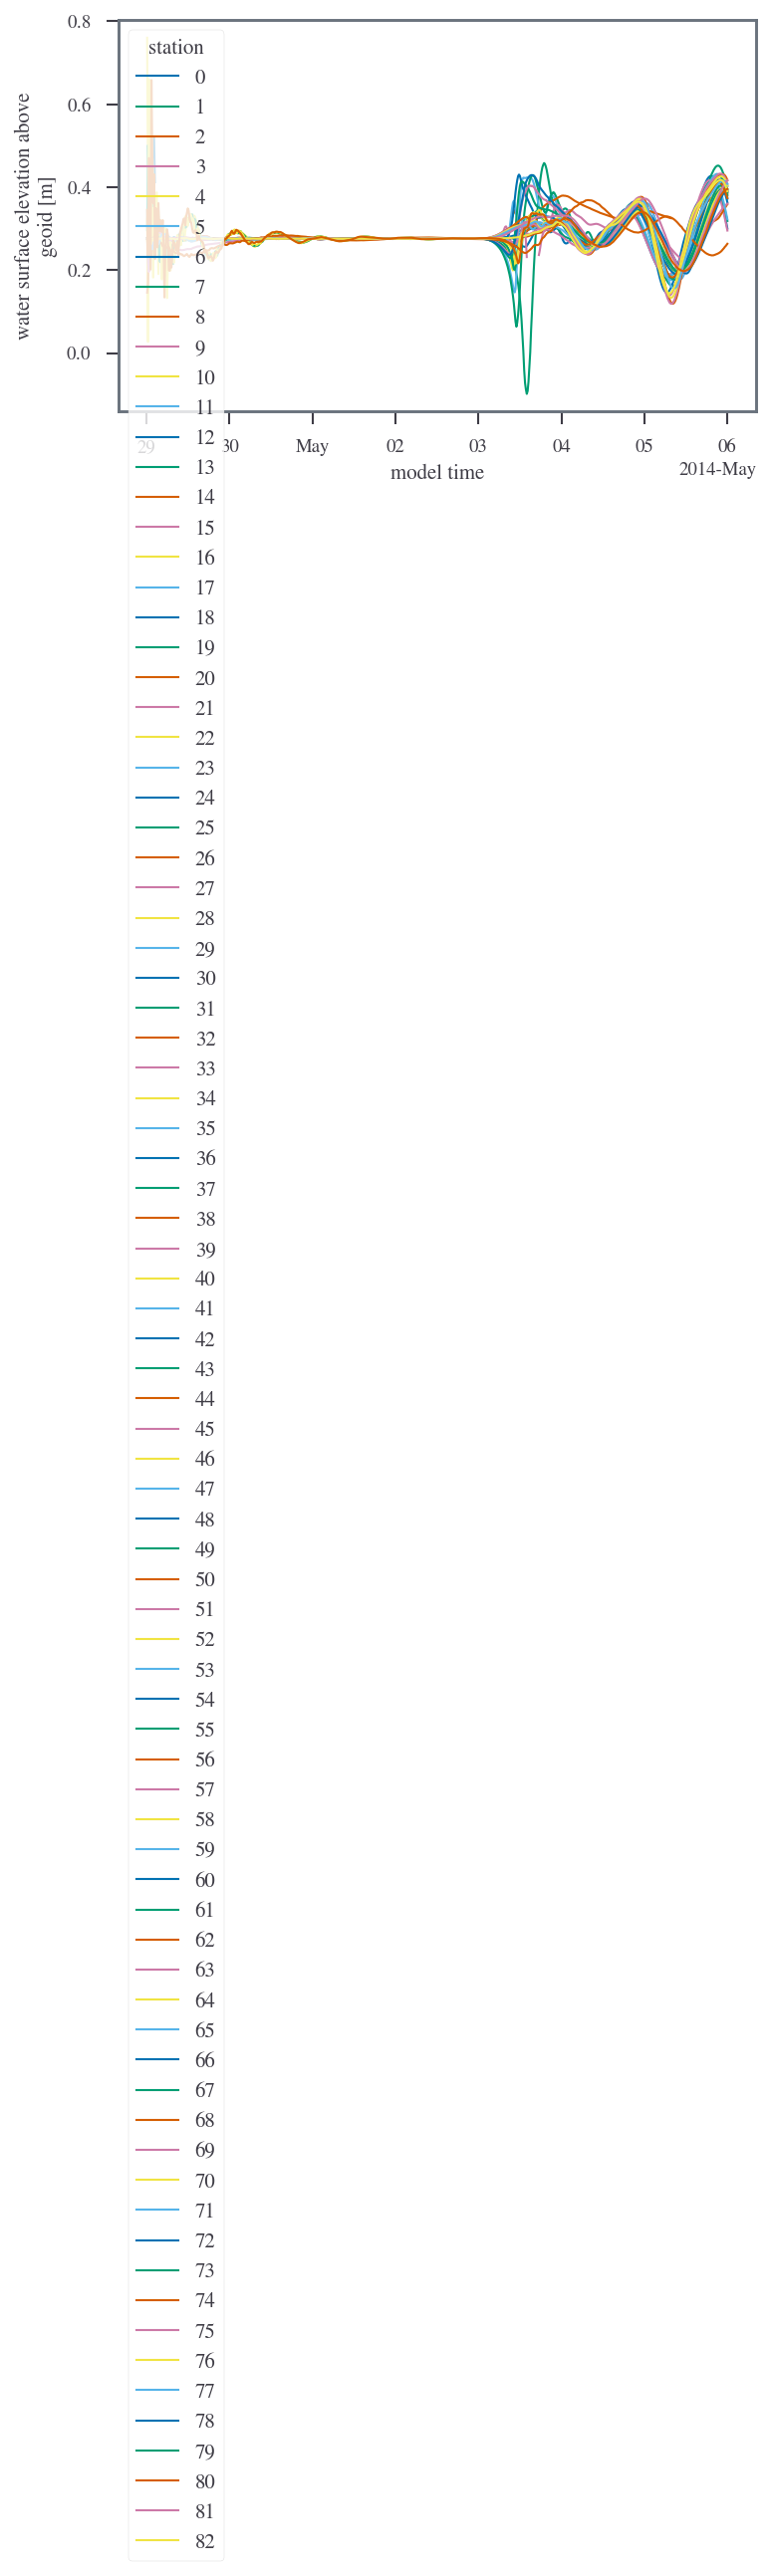

In [5]:
station_nc.zeta.plot.line(x="time")

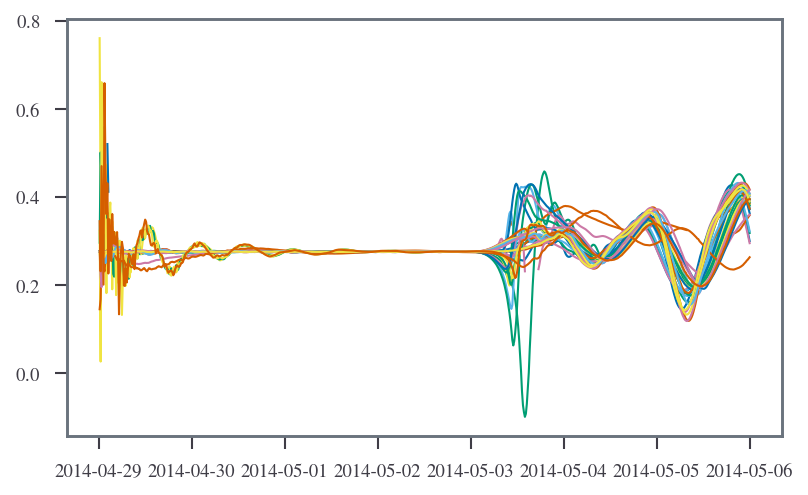

In [6]:
plt.plot(station_nc.time.values, station_nc.zeta.values)

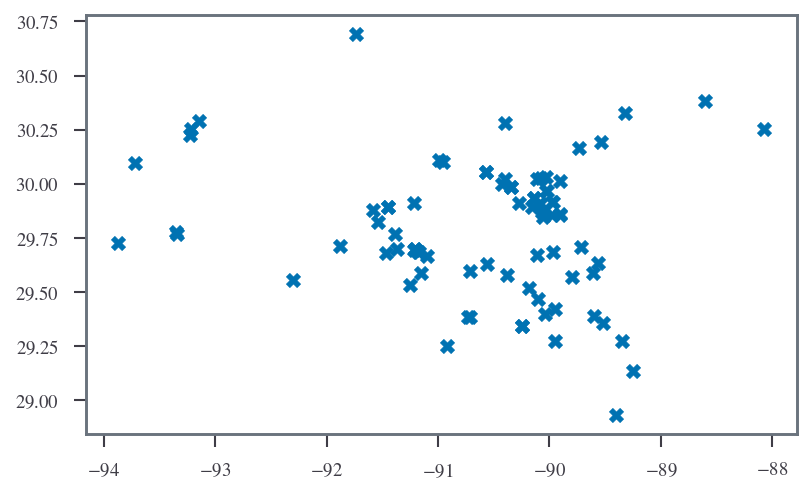

In [7]:
plt.scatter(station_nc.x.values, station_nc.y.values)

In [8]:
from adforce.fort22 import read_fort22

In [9]:
read_fort22("../../kat.nws13/fort.22.nc")

DataTree('None', parent=None)
│   Dimensions:  ()
│   Data variables:
│       *empty*
│   Attributes:
│       group_order:  Main TC1
│       institution:  Oceanweather Inc. (OWI)
│       conventions:  CF-1.6 OWI-NWS13
├── DataTree('Main')
│       Dimensions:  (time: 673, yi: 385, xi: 393)
│       Coordinates:
│           lon      (yi, xi) float64 ...
│           lat      (yi, xi) float64 ...
│         * time     (time) datetime64[ns] 2004-08-09 2004-08-09T00:15:00 ... 2004-08-16
│       Dimensions without coordinates: yi, xi
│       Data variables:
│           PSFC     (time, yi, xi) float32 ...
│           U10      (time, yi, xi) float32 ...
│           V10      (time, yi, xi) float32 ...
│       Attributes:
│           rank:     1
└── DataTree('TC1')
        Dimensions:  (time: 481, yi: 161, xi: 161)
        Coordinates:
            lon      (time, yi, xi) float64 ...
            lat      (time, yi, xi) float64 ...
          * time     (time) datetime64[ns] 2004-08-09 2004-08-09T00:15:00 ... 2004-08-14
        Dimensions without coordinates: yi, xi
        Data variables:
            clon     (time) float64 ...
            clat     (time) float64 ...
            PSFC     (time, yi, xi) float32 ...
            U10      (time, yi, xi) float32 ...
            V10      (time, yi, xi) float32 ...
        Attributes:
            rank:     2

In [10]:
f22 = read_fort22("../../kat.nws13/fort.22.nc")

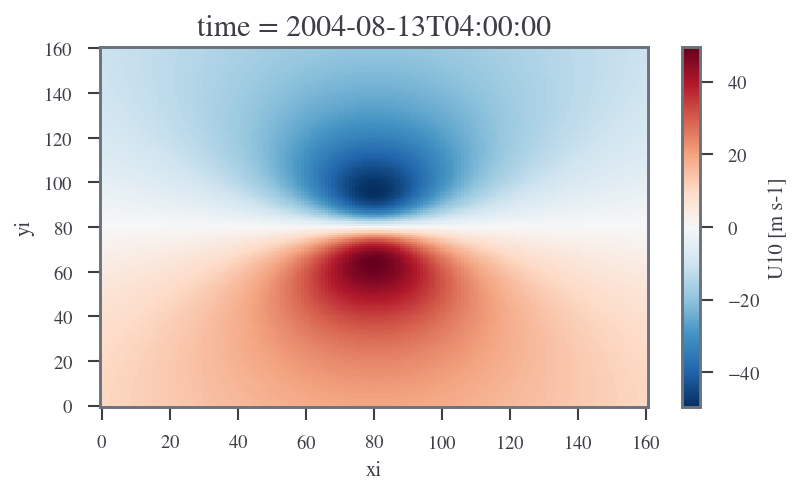

In [11]:
f22["TC1"]["U10"].isel(time=400).plot()

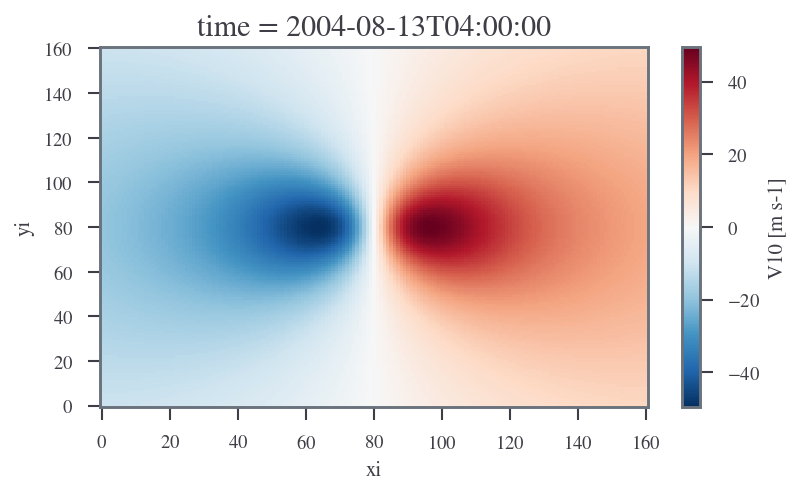

In [12]:
f22["TC1"]["V10"].isel(time=400).plot()

In [40]:
from src.constants import NO_BBOX
import pandas as pd
from sithom.plot import plot_defaults, lim
from sithom.xr import plot_units
from adforce.mesh import bbox_mesh

plot_defaults()

def plot_quiver_height(path_in: str = "mult1", time_i: int = 160, x_pos: float = 0.95, y_pos: float = -0.15) -> None:
    """
    Plot quiver height.

    Args:
        path_in (str, optional): name of data folder. Defaults to "mult1".
        time_i (int, optional): time_i. Defaults to 185.
    """
    # path_in = os.path.join(DATA_PATH, path_in)
    ds = bbox_mesh(os.path.join(path_in, "fort.63.nc"), bbox=NO_BBOX.pad(0.3), use_dask=True)
    print(ds)
    vmin, vmax = ds.zeta.min().values, ds.zeta.max().values
    vmin, vmax = np.min([-vmax, vmin]), np.max([-vmin, vmax])
    print(vmin, vmax)
    levels = np.linspace(vmin, vmax, num=400)
    cbar_levels = np.linspace(vmin, vmax, num=5)
    plt.tricontourf(
            ds.x.values,
            ds.y.values,
            ds.element.values -1,
            np.nan_to_num(ds.zeta.isel(time=time_i).values,copy=False, nan=0),
            vmin=vmin,
            vmax=vmax,
            levels=levels,
            cmap="cmo.balance",
        )
    ax = plt.gca()
    cbar = plt.colorbar(label="Height [m]")
    cbar.set_ticks(cbar_levels)
    cbar.set_ticklabels(["{:.2f}".format(x) for x in cbar_levels.tolist()])
    plt.xlabel("Longitude [$^{\circ}$E]")
    plt.ylabel("Latitude [$^{\circ}$N]")
    time = ds.isel(time=time_i).time.values
    ts = pd.to_datetime(str(time))
    print(ts)
    # plt.savefig(os.path.join(output_path, str(time_i) + ".png"))
    # plt.clf()
    ds = read_fort22(os.path.join(path_in, "fort.22.nc"))["Main"].to_dataset()
    print(ds)
    quiver = plot_units(
        ds.sel(time=time, method="nearest"), 
        x_dim="lon", 
        y_dim="lat"
    ).plot.quiver(
        ax=ax,
        x="lon",
        y="lat",
        u="U10",
        v="V10",
        add_guide=False,
    )
    _ = plt.quiverkey(
        quiver,
        # 1.08,
        x_pos,
        y_pos,  # 08,
        40,
        str(r"$40$ m s$^{-1}$"),  # + "\n"
        labelpos="E",
        coordinates="axes",
        # coordinates="figure"
    )
    NO_BBOX.ax_lim(plt.gca())
    plt.title(ts.strftime("%Y-%m-%d  %H:%M"))
    # plt.savefig(os.path.join(FIGURE_PATH, "example_colision.png"))
    # plt.clf()

'xr_loader'  3.90726 s 

'filter_mesh'  0.66990 s 

'bbox_mesh'  4.79395 s 

<xarray.Dataset>
Dimensions:      (time: 168, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T01:00:00 ... 2014-05-06
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

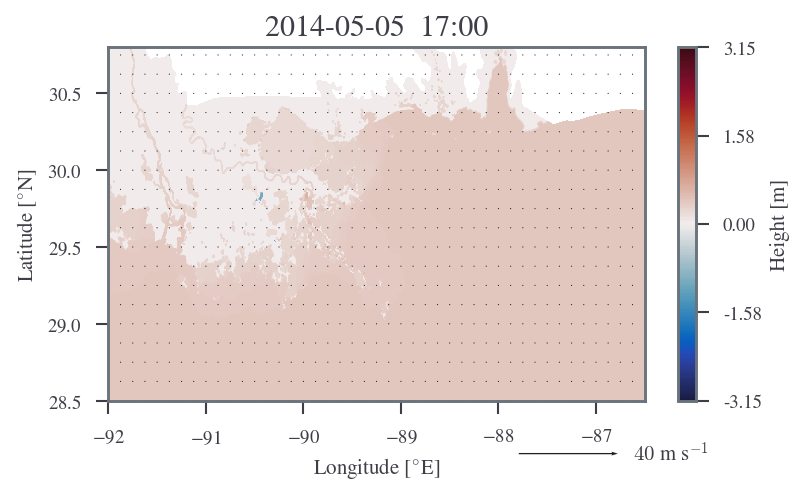

In [41]:
plot_quiver_height("../../kat.nws13")

'xr_loader'  3.18548 s 

'filter_mesh'  0.64549 s 

'bbox_mesh'  4.13702 s 

<xarray.Dataset>
Dimensions:      (time: 168, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T01:00:00 ... 2014-05-06
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

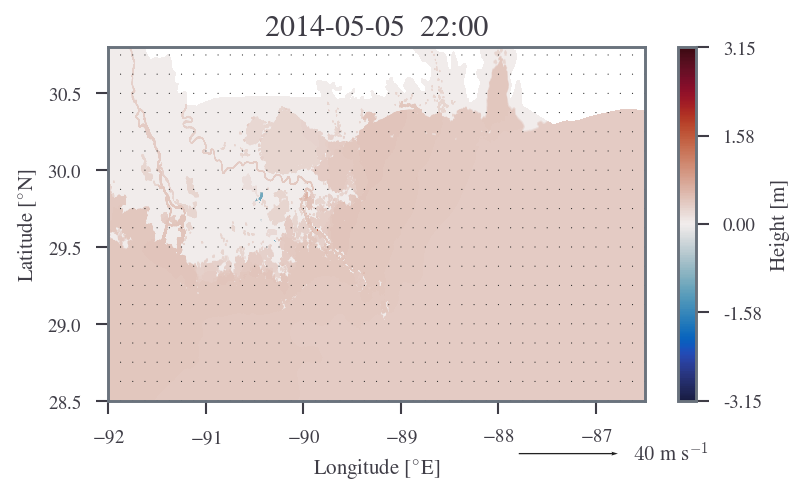

In [42]:
plot_quiver_height("../../kat.nws13", time_i=165)

'xr_loader'  8.75755 s 

'filter_mesh'  0.73811 s 

'bbox_mesh'  9.85955 s 

<xarray.Dataset>
Dimensions:      (time: 168, node: 233971, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 465356, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T01:00:00 ... 2014-05-06
    x            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(233971,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=n

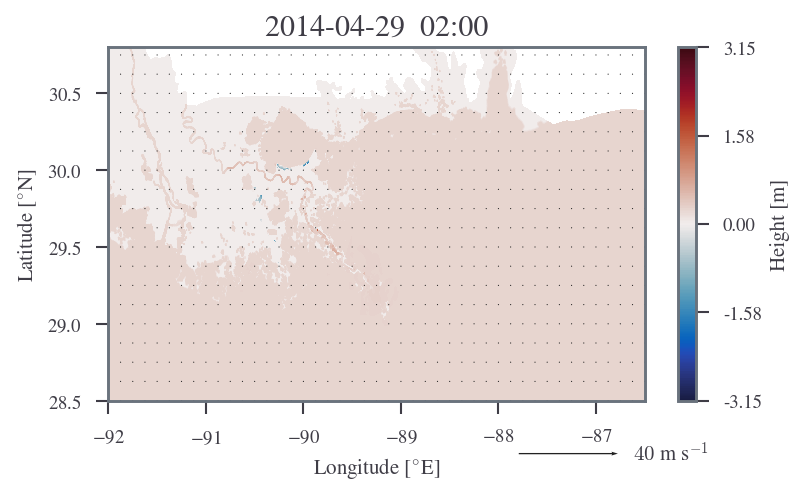

In [43]:
plot_quiver_height("../../kat.nws13", time_i=1)

In [ ]:
ds = bbox_mesh(os.path.join("../../kat.nws13", "fort.63.nc"), bbox=NO_BBOX)

'xr_loader'  0.03696 s 

'filter_mesh'  0.50735 s 

'bbox_mesh'  2.98614 s 



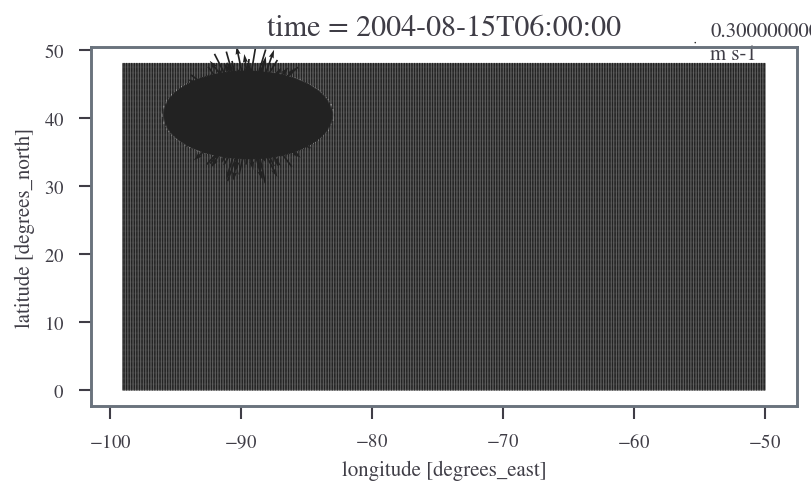

In [37]:
dnew.to_dataset().plot.quiver(x="lon", y="lat", u="U10", v="V10")

In [23]:
xr.__version__

'2024.1.1'

In [ ]:
ds

<xarray.Dataset>
Dimensions:      (time: 168, node: 209774, mesh: 1, nope: 2, neta: 122,
                  nbou: 15, nvel: 8316, nele: 417406, nvertex: 3)
Coordinates:
  * time         (time) datetime64[ns] 2014-04-29T01:00:00 ... 2014-05-06
    x            (node) float64 dask.array<chunksize=(209774,), meta=np.ndarray>
    y            (node) float64 dask.array<chunksize=(209774,), meta=np.ndarray>
Dimensions without coordinates: node, mesh, nope, neta, nbou, nvel, nele,
                                nvertex
Data variables:
    adcirc_mesh  (mesh) int32 dask.array<chunksize=(1,), meta=np.ndarray>
    nvdll        (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    max_nvdll    int32 ...
    ibtypee      (nope) int32 dask.array<chunksize=(2,), meta=np.ndarray>
    nbdv         (neta) int32 dask.array<chunksize=(122,), meta=np.ndarray>
    nvell        (nbou) int32 dask.array<chunksize=(15,), meta=np.ndarray>
    max_nvell    int32 ...
    ibtype       (nbou) int32 dask.array<chunksize=(15,), meta=np.ndarray>
    nbvv         (nvel) int32 dask.array<chunksize=(8316,), meta=np.ndarray>
    depth        (node) float64 dask.array<chunksize=(209774,), meta=np.ndarray>
    zeta         (time, node) float64 dask.array<chunksize=(1, 209774), meta=np.ndarray>
    element      (nele, nvertex) int64 4 5 1 1 5 ... 195449 163564 195449 196629
Attributes: (12/49)
    _FillValue:         -99999.0
    model:              ADCIRC
    version:            1060562
    grid_type:          Triangular
    description:        ﻿ASGS      ! 32 CHARACTER ALPHANUMERIC RUN DESCRIPTION
    agrid:              grid
    ...                 ...
    sfea0:              29.000000000000004
    cf:                 0.0
    eslm:               50.0
    cori:               0.0
    ntif:               8
    nbfr:               8

In [ ]:
mx = ds.zeta.max()
mx

<xarray.DataArray 'zeta' ()>
dask.array<_nanmax_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [ ]:
mx.values

array(1.49041507)

In [ ]:
mn = ds.zeta.min()
mn

<xarray.DataArray 'zeta' ()>
dask.array<_nanmin_skip-aggregate, shape=(), dtype=float64, chunksize=(), chunktype=numpy.ndarray>

In [ ]:
mn.values

array(-3.1529049)

In [ ]:
ds.zeta.quantile([0.01, 0.99])